Name: Naveen Kumar B

Reg No.:212222230091

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [ ]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [ ]:
root = '/Users/naveen/Documents/CATS_DOGS'

train_data = datasets.ImageFolder(os.path.join(root, 'Train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'Test'), transform=test_transform)

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
test_loader = DataLoader(test_data, batch_size=2, shuffle=False)

class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['CAT', 'DOG']
Training images available: 18743
Testing images available:  6252


In [ ]:
VGG19model = models.vgg19(pretrained=True)

Name: Naveen Kumar B

Reg No.:212222230091

In [ ]:
for param in VGG19model.parameters():
    param.requires_grad = False

In [ ]:
torch.manual_seed(42)
VGG19model.classifier = nn.Sequential(
    nn.Linear(25088, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, 2),
    nn.LogSoftmax(dim=1)
)


In [ ]:
for param in VGG19model.parameters():
    print(param.numel())

1728
64
36864
64
73728
128
147456
128
294912
256
589824
256
589824
256
589824
256
1179648
512
2359296
512
2359296
512
2359296
512
2359296
512
2359296
512
2359296
512
2359296
512
25690112
1024
2048
2


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
VGG19model = VGG19model.to(device)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(VGG19model.classifier.parameters(), lr=0.001)

In [ ]:
import time
start_time = time.time()

epochs = 3
max_trn_batch = 88  # As per your dataset size
max_tst_batch = 20  # As per your test dataset size

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b += 1

        y_pred = VGG19model(X_train)
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    acc = trn_corr.item() * 100 / (max_trn_batch * train_loader.batch_size)
    print(f"Epoch: {i+1}  Batch: {b}  Loss: {loss.item():.4f}  Accuracy: {acc:.2f}%")

    train_losses.append(loss)
    train_correct.append(trn_corr)

    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            y_val = VGG19model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds')  # print the time elapsed


Epoch: 1  Batch: 88  Loss: 0.0000  Accuracy: 96.31%
Epoch: 2  Batch: 88  Loss: 0.0000  Accuracy: 96.88%
Epoch: 3  Batch: 88  Loss: 2.2621  Accuracy: 98.30%

Duration: 170 seconds


In [ ]:
print(f"Epoch: {i+1}  Batch: {b}  Loss: {loss.item():.4f} "
      f"Accuracy: {trn_corr.item()*100/(max_trn_batch*train_loader.batch_size):.2f}%")


Epoch: 3  Batch: 20  Loss: 0.0000 Accuracy: 98.30%


Name: Naveen Kumar B

Reg No.:212222230091

In [ ]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/len(test_data):.3f}%')

[tensor(39), tensor(39), tensor(40)]
Test accuracy: 0.640%


In [ ]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

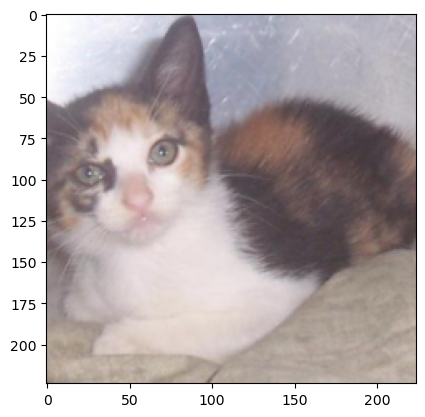

In [ ]:
image_index = 15
im = inv_normalize(test_data[image_index][0])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));
plt.show()



In [ ]:
VGG19model.eval()
with torch.no_grad():
    new_pred = VGG19model(test_data[image_index][0].view(1,3,224,224)).argmax()

class_names[new_pred.item()]

'CAT'